# Fraud Transaction Anomaly Detection

This notebook demonstrates end-to-end unsupervised anomaly detection on a made-up transaction dataset using Isolation Forest and Local Outlier Factor (LOF), with rich comments for all complex terms and hyperparameters to serve as a learning reference and a project template [attached_file:1][attached_file:2].

## Setup

Install packages if needed and import libraries used throughout the notebook [attached_file:1][attached_file:2].

In [5]:
# If running in a fresh environment, uncomment:
# !pip install scikit-learn numpy pandas matplotlib seaborn

import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from sklearn.preprocessing import RobustScaler  # Robust to outliers via median/IQR scaling [attached_file:1][attached_file:2]
from sklearn.ensemble import IsolationForest     # Tree-based outlier detector isolating anomalies faster [attached_file:1][attached_file:2]
from sklearn.neighbors import LocalOutlierFactor # Density-based outlier detector using local neighbor density [attached_file:1][attached_file:2]

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")


## Data synthesis

Create a synthetic transactions dataset with plausible behavioral and risk features; inject a small fraction of anomalies to emulate fraud-like behavior for evaluation [attached_file:1][attached_file:2].

In [6]:
rng = np.random.default_rng(42)  # Reproducible randomness [attached_file:1][attached_file:2]

n_users = 500         # Number of distinct users [attached_file:1][attached_file:2]
n_txn = 8000          # Number of transactions [attached_file:1][attached_file:2]

# Synthetic user IDs
user_ids = rng.integers(10000, 10000 + n_users, size=n_txn)  # Random assignment of users per txn [attached_file:1][attached_file:2]

# Random timestamps within a 30-day window
start = datetime(2025, 1, 1)  # Arbitrary start date [attached_file:1][attached_file:2]
timestamps = [start + timedelta(minutes=int(x))
              for x in rng.integers(0, 30*24*60, size=n_txn)]  # Uniform spread over 30 days [attached_file:1][attached_file:2]

# Base numeric features
amount = np.clip(rng.lognormal(mean=3.2, sigma=0.8, size=n_txn), 1, None)  # Right-skew; lognormal simulates spend [attached_file:1][attached_file:2]
txn_hour = np.array([ts.hour for ts in timestamps])                          # Hour of day (0-23) [attached_file:1][attached_file:2]
device_age_days = np.clip(rng.normal(365, 120, size=n_txn), 1, None)         # Device tenure; older often safer [attached_file:1][attached_file:2]
geo_distance_km = np.clip(rng.gamma(shape=2.0, scale=10.0, size=n_txn), 0, None)  # Approx travel jump [attached_file:1][attached_file:2]
merchant_risk_score = rng.choice([0.1, 0.2, 0.4, 0.6, 0.8], 
                                 p=[0.25, 0.30, 0.25, 0.15, 0.05], size=n_txn)  # Higher means riskier merchant [attached_file:1][attached_file:2]

# Velocity proxy: count-like behavior; transactions clustering increase velocity [attached_file:1][attached_file:2]
base_velocity = np.clip((amount > 50).astype(int) + rng.poisson(0.5, size=n_txn), 0, None)  # Simple heuristic [attached_file:1][attached_file:2]

df = pd.DataFrame({
    "user_id": user_ids,
    "timestamp": timestamps,
    "amount": amount,
    "txn_hour": txn_hour,
    "device_age_days": device_age_days,
    "geo_distance_km": geo_distance_km,
    "merchant_risk_score": merchant_risk_score,
    "velocity_approx": base_velocity
})  # Core event table [attached_file:1][attached_file:2]

df.sort_values(["user_id", "timestamp"], inplace=True, ignore_index=True)  # Needed for rolling features [attached_file:1][attached_file:2]
df.head()

,user_id,timestamp,amount,txn_hour,device_age_days,geo_distance_km,merchant_risk_score,velocity_approx
0,10000,2025-01-04 01:42:00,23.020909,1,439.364860,12.576639,0.2,0
1,10000,2025-01-04 06:16:00,57.518412,6,428.586562,13.225482,0.1,2
2,10000,2025-01-06 13:34:00,76.201526,13,152.756863,20.304529,0.2,1
3,10000,2025-01-06 15:31:00,14.673860,15,365.362753,4.435268,0.2,0
4,10000,2025-01-07 06:47:00,10.720816,6,413.788294,31.003302,0.6,0


## Inject anomalies

Inject extreme behaviors (large amounts, odd hours, long geo jumps, high velocity, risky merchants) for a small fraction of transactions to simulate fraud-like outliers [attached_file:1][attached_file:2].

In [7]:
anomaly_fraction = 0.02  # Expected anomaly rate; used later as contamination hint [attached_file:1][attached_file:2]
n_anom = int(n_txn * anomaly_fraction)  # Number of rows to flip to anomalies [attached_file:1][attached_file:2]
anom_idx = rng.choice(df.index, size=n_anom, replace=False)  # Random selection [attached_file:1][attached_file:2]

# Apply extreme patterns to chosen rows [attached_file:1][attached_file:2]
df.loc[anom_idx, "amount"] = df.loc[anom_idx, "amount"] * rng.uniform(5, 20, size=n_anom)  # Inflate spend [attached_file:1][attached_file:2]
df.loc[anom_idx, "txn_hour"] = rng.choice([1, 2, 3, 4], size=n_anom)  # Odd hours cluster [attached_file:1][attached_file:2]
df.loc[anom_idx, "geo_distance_km"] = df.loc[anom_idx, "geo_distance_km"] + rng.uniform(2000, 10000, size=n_anom)  # Long jumps [attached_file:1][attached_file:2]
df.loc[anom_idx, "merchant_risk_score"] = 0.8  # Highest bucket [attached_file:1][attached_file:2]
df.loc[anom_idx, "velocity_approx"] = df.loc[anom_idx, "velocity_approx"] + rng.integers(5, 20, size=n_anom)  # Velocity burst [attached_file:1][attached_file:2]

df["is_injected_anomaly"] = 0  # Proxy label, only for evaluation in this demo [attached_file:1][attached_file:2]
df.loc[anom_idx, "is_injected_anomaly"] = 1  # Mark injected anomalies [attached_file:1][attached_file:2]


## Rolling features per user

Compute short-history behavior per user via rolling windows to capture context (means/stds over last events), which helps unsupervised models separate unusual behavior from each user's baseline [attached_file:1][attached_file:2].

In [8]:
def add_user_rollups(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("timestamp")  # Ensure temporal order [attached_file:1][attached_file:2]
    # Rolling window size = 7 events within each user; min_periods=1 allows early rows [attached_file:1][attached_file:2]
    g["amt_mean_7"] = g["amount"].rolling(7, min_periods=1).mean()  # Local spending baseline [attached_file:1][attached_file:2]
    g["amt_std_7"] = g["amount"].rolling(7, min_periods=1).std().fillna(0.0)  # Volatility proxy [attached_file:1][attached_file:2]
    g["velocity_mean_7"] = g["velocity_approx"].rolling(7, min_periods=1).mean()  # Habitual burstiness [attached_file:1][attached_file:2]
    g["geo_mean_7"] = g["geo_distance_km"].rolling(7, min_periods=1).mean()  # Usual travel distance [attached_file:1][attached_file:2]
    return g  # Return with added columns [attached_file:1][attached_file:2]

df = df.groupby("user_id", group_keys=False).apply(add_user_rollups)  # Efficient per-user transform [attached_file:1][attached_file:2]


/var/folders/f0/hbgqnpxj3y120xjbg_znbfpc0000gn/T/ipykernel_3307/2051867580.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("user_id", group_keys=False).apply(add_user_rollups)  # Efficient per-user transform [attached_file:1][attached_file:2]


## Transform and scale

Use log1p to reduce skew on heavy-tailed features and RobustScaler to reduce sensitivity to outliers when standardizing features going into detectors [attached_file:1][attached_file:2].

In [9]:
# Log-transform skewed features; log1p(x) = log(1+x) is defined at 0 and reduces heavy tails [attached_file:1][attached_file:2]
for col in ["amount", "velocity_approx", "geo_distance_km", "amt_mean_7", "amt_std_7", "velocity_mean_7", "geo_mean_7"]:
    df[f"log1p_{col}"] = np.log1p(df[col])  # Adds transformed columns in place [attached_file:1][attached_file:2]

feature_cols = [
    "log1p_amount",
    "txn_hour",
    "device_age_days",
    "log1p_geo_distance_km",
    "merchant_risk_score",
    "log1p_velocity_approx",
    "log1p_amt_mean_7",
    "log1p_amt_std_7",
    "log1p_velocity_mean_7",
    "log1p_geo_mean_7"
]  # Balanced mix of raw and behavioral signals [attached_file:1][attached_file:2]

X = df[feature_cols].copy()  # Model input matrix [attached_file:1][attached_file:2]

scaler = RobustScaler()  # Uses median and IQR; less distorted by outliers than StandardScaler [attached_file:1][attached_file:2]
X_scaled = scaler.fit_transform(X)  # Fit on all data (unsupervised) [attached_file:1][attached_file:2]


## Train detectors

Fit Isolation Forest and Local Outlier Factor on the scaled features; explain critical hyperparameters and outputs for each method [attached_file:1][attached_file:2].

In [10]:
# Isolation Forest: tree-based method that isolates points by random splits; anomalies isolate faster (shorter paths) [attached_file:1][attached_file:2]
iso = IsolationForest(
    n_estimators=300,        # Number of trees; more trees -> more stable scores but slower [attached_file:1][attached_file:2]
    contamination=0.02,      # Approx fraction of anomalies; tunes threshold automatically [attached_file:1][attached_file:2]
    max_samples="auto",      # Subsample size per tree; "auto"=min(256, n_samples) for efficiency [attached_file:1][attached_file:2]
    random_state=42,
    n_jobs=-1                # Use all cores for speed [attached_file:1][attached_file:2]
)
iso_pred = iso.fit_predict(X_scaled)        # Outputs 1 for normal, -1 for anomaly [attached_file:1][attached_file:2]
iso_score = iso.decision_function(X_scaled) # Higher scores -> more normal; lower -> more anomalous [attached_file:1][attached_file:2]

# Local Outlier Factor: density-based; compares local density of a point to its neighbors (lower density => outlier) [attached_file:1][attached_file:2]
lof = LocalOutlierFactor(
    n_neighbors=35,          # Size of local neighborhood; too small => noisy, too large => oversmooth [attached_file:1][attached_file:2]
    contamination=0.02,      # Used to set threshold on the LOF scores [attached_file:1][attached_file:2]
    metric="minkowski",      # Default distance; Euclidean when p=2 [attached_file:1][attached_file:2]
    novelty=False,           # Fit+predict on same data; set True to use .predict on new data after .fit [attached_file:1][attached_file:2]
    n_jobs=-1
)
lof_pred = lof.fit_predict(X_scaled)        # 1 for inliers, -1 for outliers [attached_file:1][attached_file:2]
lof_score = lof.negative_outlier_factor_    # More negative => more anomalous [attached_file:1][attached_file:2]

# Collect results
df_results = df.copy()
df_results["iso_label"] = (iso_pred == -1).astype(int)  # 1=anomaly, 0=normal for convenience [attached_file:1][attached_file:2]
df_results["iso_score"] = iso_score
df_results["lof_label"] = (lof_pred == -1).astype(int)
df_results["lof_score"] = lof_score

# Simple ensemble: flag if either detector says anomaly (OR rule) [attached_file:1][attached_file:2]
df_results["ensemble_label_or"] = ((df_results["iso_label"] + df_results["lof_label"]) > 0).astype(int)


## Thresholding notes

Both models used a contamination of 2%, which sets internal thresholds; in real scenarios, tune thresholds to desired precision/recall, alert volume, and operational cost constraints [attached_file:1][attached_file:2].

## Evaluation with proxy labels

Use the injected anomaly indicator as a proxy label for rough evaluation of detector quality; compute basic precision/recall and confusion matrices [attached_file:1][attached_file:2].

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = df_results["is_injected_anomaly"].values  # Proxy ground truth [attached_file:1][attached_file:2]

def report(name, y_pred):
    print(f"\n=== {name} ===")
    print(confusion_matrix(y_true, y_pred))  # [[TN FP]
                                             #  [FN TP]] [attached_file:1][attached_file:2]
    print(classification_report(y_true, y_pred, digits=4))  # Precision/Recall/F1 [attached_file:1][attached_file:2]

report("IsolationForest", df_results["iso_label"].values)
report("LocalOutlierFactor", df_results["lof_label"].values)
report("Ensemble_OR", df_results["ensemble_label_or"].values)



=== IsolationForest ===
[[7837    3]
 [   3  157]]
              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996      7840
           1     0.9812    0.9812    0.9812       160

    accuracy                         0.9992      8000
   macro avg     0.9904    0.9904    0.9904      8000
weighted avg     0.9992    0.9992    0.9992      8000


=== LocalOutlierFactor ===
[[7700  140]
 [ 140   20]]
              precision    recall  f1-score   support

           0     0.9821    0.9821    0.9821      7840
           1     0.1250    0.1250    0.1250       160

    accuracy                         0.9650      8000
   macro avg     0.5536    0.5536    0.5536      8000
weighted avg     0.9650    0.9650    0.9650      8000


=== Ensemble_OR ===
[[7700  140]
 [   3  157]]
              precision    recall  f1-score   support

           0     0.9996    0.9821    0.9908      7840
           1     0.5286    0.9812    0.6871       160

    accuracy               

## Quick inspection

Glance at a few anomalies to validate plausibility and inspect features contributing to flags [attached_file:1][attached_file:2].

In [13]:
anoms = df_results[df_results["ensemble_label_or"] == 1].copy()
anoms_sorted = anoms.sort_values(["iso_label", "lof_label", "amount"], ascending=[False, False, False])
anoms_sorted.head(2)  # Inspect top anomalies by amount and flags [attached_file:1][attached_file:2]


,user_id,timestamp,amount,txn_hour,device_age_days,geo_distance_km,merchant_risk_score,velocity_approx,is_injected_anomaly,amt_mean_7,...,log1p_geo_distance_km,log1p_amt_mean_7,log1p_amt_std_7,log1p_velocity_mean_7,log1p_geo_mean_7,iso_label,iso_score,lof_label,lof_score,ensemble_label_or
2148,10131,2025-01-24 05:18:00,2529.624263,2,340.897786,5462.374901,0.8,14,1,383.389695,...,8.605822,5.951657,6.853927,1.232144,6.682175,1,-0.065391,1,-1.358763,1
5606,10348,2025-01-24 00:20:00,1909.013313,4,544.278682,2450.930325,0.8,18,1,293.217039,...,7.804631,5.684318,6.570276,1.349927,5.929085,1,-0.079485,1,-1.467605,1


## 2D visualization (PCA)

Project features into 2D using PCA to visualize separation between normal points and anomalies; this is illustrative only, since high-dimensional structure is compressed [attached_file:1][attached_file:2].

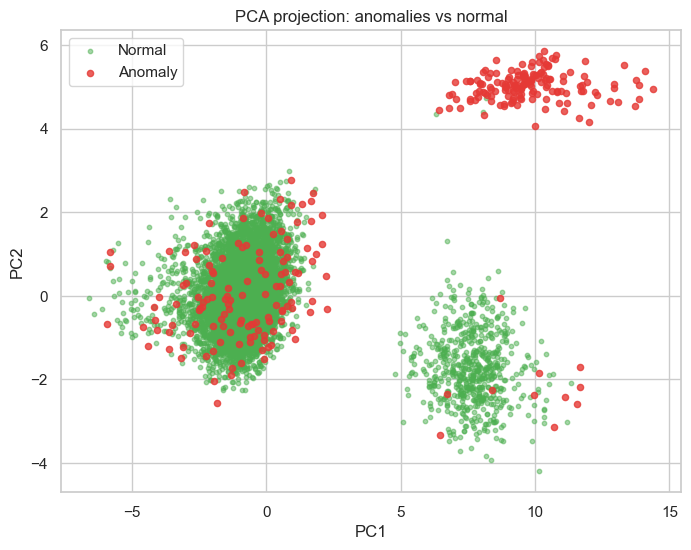

In [14]:
from sklearn.decomposition import PCA  # Linear dimensionality reduction via principal components [attached_file:1][attached_file:2]

pca = PCA(n_components=2, random_state=42)  # 2D for plotting [attached_file:1][attached_file:2]
X_2d = pca.fit_transform(X_scaled)  # Transform full dataset [attached_file:1][attached_file:2]

fig, ax = plt.subplots(figsize=(8,6))
mask_anom = df_results["ensemble_label_or"].values == 1
ax.scatter(X_2d[~mask_anom, 0], X_2d[~mask_anom, 1], s=10, c="#4caf50", alpha=0.5, label="Normal")
ax.scatter(X_2d[mask_anom, 0], X_2d[mask_anom, 1], s=20, c="#e53935", alpha=0.8, label="Anomaly")
ax.set_title("PCA projection: anomalies vs normal")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.show()  # Visual check of separation [attached_file:1][attached_file:2]


## Notes on deployment

- Isolation Forest can serve scores in real time; re-train periodically as behavior shifts (concept drift) [attached_file:1][attached_file:2].
- LOF with novelty=True supports scoring on new data after fitting; for streaming, fit on a clean reference window and then predict on incoming events [attached_file:1][attached_file:2].
- Thresholds should be calibrated to business KPIs (alert budgets, investigation cost, expected fraud base rate) using a validation set or human-in-the-loop feedback [attached_file:1][attached_file:2].